In [112]:
# pip install -U dataprep

In [113]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from pandas import Series
import pandas as pd
import pandas_profiling
import numpy as np
from datetime import datetime, timedelta

# from dataprep.eda import plot, plot_correlation, create_report, plot_missing

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,RobustScaler

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import confusion_matrix,classification_report,recall_score, precision_score
from sklearn.metrics import auc, roc_auc_score, roc_curve,f1_score,plot_precision_recall_curve, plot_roc_curve

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
path = '/kaggle/input/sf-dst-scoring/'
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Функции

In [114]:
'''Функция, возвращающая порядковый день в году'''

def get_days_count(x):  
    day = ((x.month-1) * 30)+x.day
    return day

'''Функция, возвращающая количество дней между датой заявки и сегодняшним числом'''

def get_days_beetwen(x):
    curr_date = datetime.today()
    count = (curr_date-x).days
    return count
    

'''Функция, возвращающая флаг подачи заявки в выходной день'''

def if_weekend(x):
    if x.weekday() in [5,6]:
        return 1
    else:
        return 0
    
    
def month(x):
    month = x.month
    return month
    

In [115]:
def get_boxplot(data,col1,col2,hue=None):
    '''Function is called to plot boxplots'''
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.boxplot(x=col1, y=col2, hue=hue,data=data, palette='mako')
    plt.xticks(rotation=45)
#     ax.set_title('Boxplot for ' + col1 + 'and' + col2,fontsize=14)
    ax.set_title(f'Boxplot for {col1} and {col2}',fontsize=14)
    plt.show()

In [116]:
'''Функция, определяющая флаг наличия поручителя среди людей с образованием 'PGR' и 'ACD'  '''
def has_no_garant(edu,grnt):
    if edu == 'PGR' or edu == 'ACD':
        grnt = 1
        return grnt             
    else: 
        grnt = 0
        return grnt
    

In [1]:
class Preprocessing:
    def __init__(self,data):
        self.data = data
#         self.column = column
    
    def label_encoder(self,column):
        le = LabelEncoder()
        self.data[column] = le.fit_transform(self.data[column])
        
    def hot_enc(self,column):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        aux_df = pd.DataFrame(ohe.fit_transform(self.data[[column]]))
        aux_df.columns = ohe.get_feature_names(['hot_encode'])
        self.data = self.data.drop(col,axis=1)
        self.data = pd.concat([self.data, aux_df], axis=1)
        return self.data

In [118]:
def corr_matrix(data, det=True, pltx = 10, plty=10):
    X = data.corr()
    if det:
        
        evals,evec = np.linalg.eig(X)
        ev_product = np.prod(evals)
    
        print(f'Rank of Matrix: {np.linalg.matrix_rank(X)}')
        print(f'Determinat of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(X)}')
    
    plt.figure(figsize=(pltx,plty))
    sns.heatmap(X,vmin=0,vmax=.9,cmap='mako',annot=True,square=True)
    plt.show()

In [119]:
def pre_processing(column,data):
    '''Function is called to encode feature'''
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])

# Загрузка данных

In [120]:
# train = pd.read_csv(path+'train.csv')
# test = pd.read_csv(path+'test.csv')
# sub = pd.read_csv(path+'sample_submission.csv')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

print(f'Размерность тренировочного датасета: {train.shape}')
print(f'Размерность тестового датасета: {test.shape}')

Размерность тренировочного датасета: (73799, 19)
Размерность тестового датасета: (36349, 18)


In [121]:
train[:4]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0


In [122]:
test[:4]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N


In [123]:
sub[:4]

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501


### Проверим, пересекаются ли данные в тренировочном и тестовом датасетах


In [124]:
set(test.client_id) & set(set(train.client_id))

set()

##### (Не пересекаются)

### Объединяем таблицы с добавлением параметра-указателя принадлежности к тестовой выборке

In [125]:
train['test'] = 0
test['test'] = 1
df = pd.concat([train, test], axis=0)

client_id           0.000000
app_date            0.000000
education           0.415995
sex                 0.000000
age                 0.000000
car                 0.000000
car_type            0.000000
decline_app_cnt     0.000000
good_work           0.000000
score_bki           0.000000
bki_request_cnt     0.000000
region_rating       0.000000
home_address        0.000000
work_address        0.000000
income              0.000000
sna                 0.000000
first_time          0.000000
foreign_passport    0.000000
default             0.000000
test                0.000000
dtype: float64


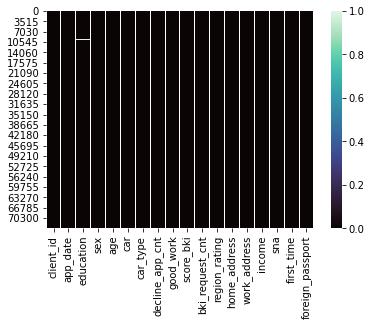

In [126]:
sns.heatmap(train.drop(['default','test'],axis=1).isnull(), cmap='mako')
print(train.isna().mean() * 100) # ВЫражаем пропуски в процентах

Описания полей
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту


####  Вывод: в тренировочной выборке   73799 записей, в тестовой 36349 записей. Имется небольшое количество пропусков в признаке education (0.43% суммарно), которые мы заполним. Данные в тренировочной и тестовой выборках не пересекаются 

In [127]:
# pandas_profiling.ProfileReport(df.drop(['client_id','default','test'],axis=1))

In [128]:
train[:3]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,0


In [129]:
edu_name = train['education'].value_counts().index.to_list() # Получаем список значений
edu_distr = train['education'].value_counts(normalize=True).values # Получаем список вероятностей
missing = train['education'].isnull() # Флаги с наличием пропусков
train.loc[missing, ['education']] = np.random.choice(
    edu_name, size=len(train[missing]), p=edu_distr) # Подставляем значения из списка имен в соответствии в вероятностью встречи имени

<AxesSubplot:>

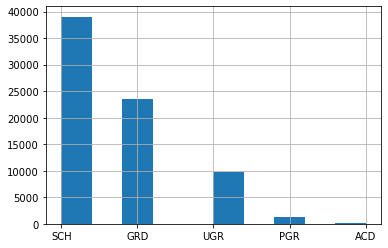

In [130]:
train['education'].hist()

## 1.Анализ данных

<function matplotlib.pyplot.show(close=None, block=None)>

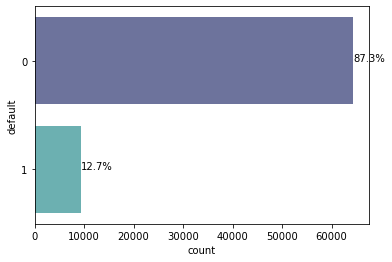

In [131]:
ax = sns.countplot(y='default', data= train, alpha=0.8,palette='mako')
total = train.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage,(x,y))
plt.show


## Имеется дисбаланс классов, попробуем его решить без применения методик по устранению дисбаланса и с ними


client_id        |73799      |int64 
app_date         |120        |object 
education        |5          |object 
sex              |2          |object 
age              |52         |int64 
car              |2          |object 
car_type         |2          |object 
decline_app_cnt  |21         |int64 
good_work        |2          |int64 
score_bki        |69096      |float64 
bki_request_cnt  |38         |int64 
region_rating    |7          |int64 
home_address     |3          |int64 
work_address     |3          |int64 
income           |966        |int64 
sna              |4          |int64 
first_time       |4          |int64 
foreign_passport |2          |object 
default          |2          |int64 
test             |1          |int64 


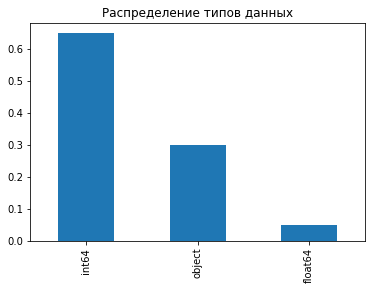

In [132]:
for i in train.columns:
    print('{0:<16} |{1:<10} |{2} '.format(i, train[i].nunique(), train[i].dtypes))
    train.dtypes.value_counts(normalize=True).plot(
        kind='bar', title='Распределение типов данных')

### Исходя из кол-ва возможных значений и описания признаков, делим признаки на числовые, категориальные и бинарные

In [133]:
bin_ = ['sex','car','car_type','foreign_passport','good_work']
num_ = ['age',  'income', 'score_bki']
cat_ = ['decline_app_cnt','bki_request_cnt','education','work_address','home_address', 'sna', 'region_rating','first_time']

## Не смотря на то, что признаки  'decline_app_cnt' и 'bki_request_cnt' похожи на числовые с выбросами, мы не будем избавляться от выбросов, но отметим эти признаки как категориальные, т.к. количество запросов в БКИ и количество отказов могут прояснить ситуацию с благополучностью и надежностью потенциального клиента.

### Посмотрим на них поближе



Распределение значений 'decline_app_cnt'

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
15        1
19        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64






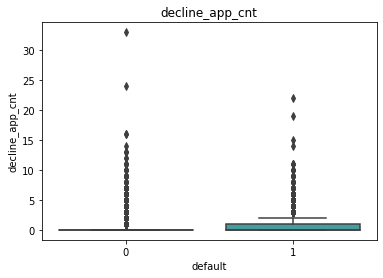



Распределение значений 'bki_request_cnt'

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
15        1
19        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64






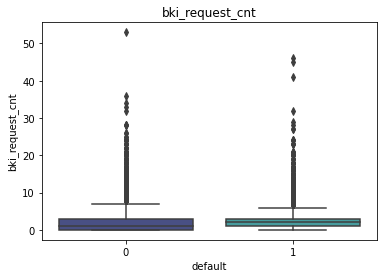

In [134]:
for i in ['decline_app_cnt','bki_request_cnt']:
    plt.figure()
    sns.boxplot(x=train['default'], y=train[i],palette='mako')
    print('\n\nРаспределение значений \'{0}\'\n\n{1}\n\n\n\n'.format(i,train["decline_app_cnt"].value_counts()))
    plt.title(i)
    plt.show()


# Числовые признаки

### Преобразуем признак с датой и добавим дополнительные фичи 

In [135]:
train['app_date'] = pd.to_datetime(train['app_date']) # Преобразуем в datetime
train['weekend'] = train['app_date'].apply(lambda x:(if_weekend(x))) # Флаг выходного дня
train['days_numb'] = train['app_date'].apply(lambda x:(get_days_count(x))) # Порядковый номер дня в году
train['days_beetwen'] = train['app_date'].apply(lambda x:(get_days_beetwen(x))) # Кол- во дней между подачей заявки и сегодняшним числом
train['month'] = train['app_date'].apply(lambda x: (month(x)))

In [136]:
train = train.drop('app_date',axis=1) # Удалим столбец app_date 

In [137]:
bin_ = bin_ + ['weekend']
num_ = num_ + ['days_numb','days_beetwen']
cat_ = cat_ + ['month']


In [138]:
train

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,income,sna,first_time,foreign_passport,default,test,weekend,days_numb,days_beetwen,month
0,25905,SCH,M,62,Y,Y,0,0,-2.008753,1,...,18000,4,1,N,0,0,1,31,2626,2
1,63161,SCH,F,59,N,N,0,0,-1.532276,3,...,19000,4,1,N,0,0,0,72,2587,3
2,25887,SCH,M,25,Y,N,2,0,-1.408142,1,...,30000,1,4,Y,0,0,1,31,2626,2
3,16222,SCH,F,53,N,N,0,0,-2.057471,2,...,10000,1,3,N,0,0,0,23,2635,1
4,101655,GRD,M,48,N,N,0,1,-1.244723,1,...,30000,1,4,Y,0,0,0,108,2550,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,GRD,F,45,N,N,0,0,-1.792064,3,...,17000,4,4,N,0,0,0,64,2595,3
73795,76821,SCH,M,41,Y,Y,0,0,-2.058029,1,...,70000,1,4,N,0,0,0,84,2575,3
73796,103695,SCH,M,31,N,N,0,0,-1.512635,4,...,45000,2,2,N,0,0,0,112,2546,4
73797,861,SCH,F,29,N,N,0,1,-1.479334,3,...,13000,2,3,N,1,0,1,4,2654,1


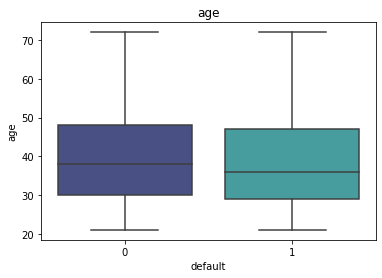

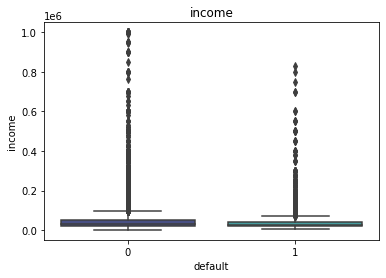

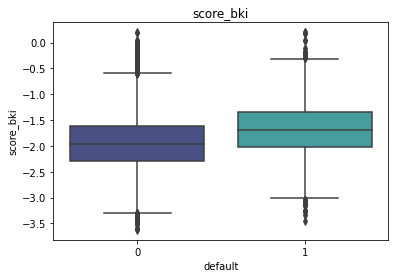

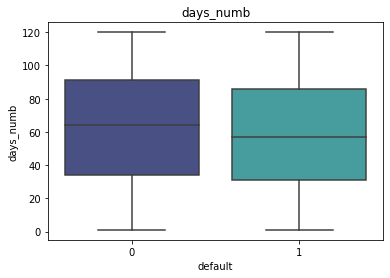

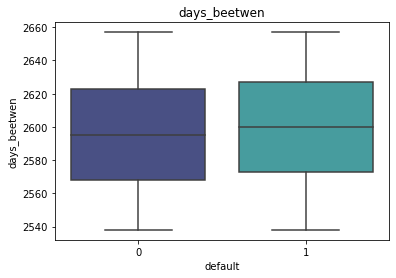

In [139]:
for i in num_:
    plt.figure()
    sns.boxplot(x=train['default'], y=train[i],palette='mako')
    plt.title(i)
    plt.show()


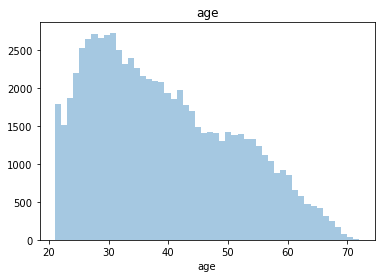

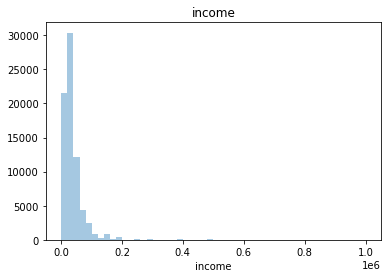

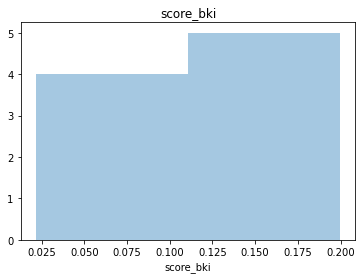

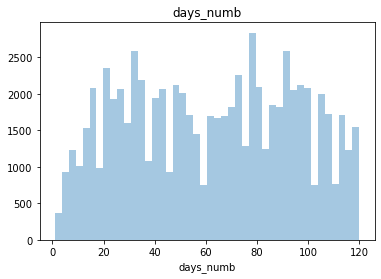

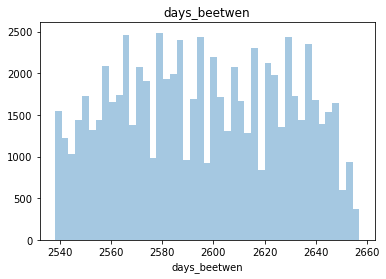

In [140]:
# Построим распределенеие числовых признаков

for i in num_:
    plt.figure()
    sns.distplot(train[i][train[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

In [141]:
'''пока не используется'''
# def get_blowout(x):
#     blowouts = dict.fromkeys(['age', 'income', 'score_bki', 'days_numb', 'days_beetwen'])
#     for i in num_:
#         Q1 = np.percentile(df[i],25)
#         Q3 = np.percentile(df[i],75)
#         q_range = Q3 - Q1        
#         right = (df[i][df[i] > (Q3+1.5*q_range)]).values
#         left = (df[i][df[i] < (Q1-1.5*q_range)]).values
#         blowouts.update({i:(set(left),set(right))})
#     return display(blowouts)





   

'пока не используется'

In [142]:
train[['sex','age']].value_counts()

sex  age
M    28     1424
     31     1394
     27     1387
     29     1375
     30     1374
            ... 
     69       18
     70        5
F    72        2
M    71        2
F    71        1
Length: 103, dtype: int64

In [143]:
train[num_]

,age,income,score_bki,days_numb,days_beetwen
0,62,18000,-2.008753,31,2626
1,59,19000,-1.532276,72,2587
2,25,30000,-1.408142,31,2626
3,53,10000,-2.057471,23,2635
4,48,30000,-1.244723,108,2550
...,...,...,...,...,...
73794,45,17000,-1.792064,64,2595
73795,41,70000,-2.058029,84,2575
73796,31,45000,-1.512635,112,2546
73797,29,13000,-1.479334,4,2654


### Видим, что на графиках имеется выраженный хвост вправо. Прологарифмируем.

In [144]:
'''ЛОГАРИФМИРОВАНИЕ'''
train['score_bki'] = train['score_bki'] + 99 # Прибавили число, чтобы избавитья от inf значений 
for col in num_:
    train[col] = np.log(train[col])

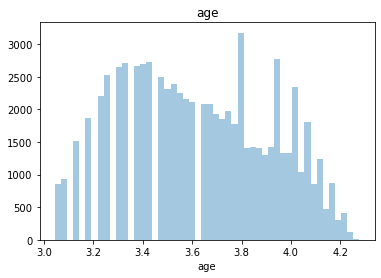

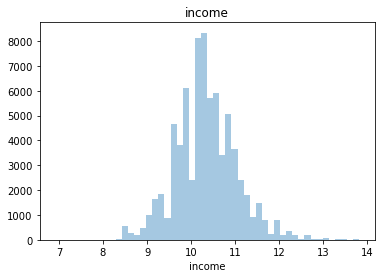

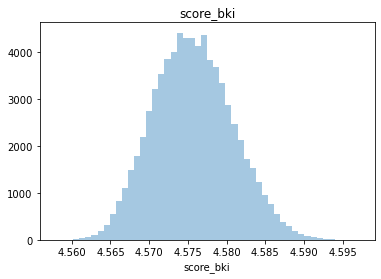

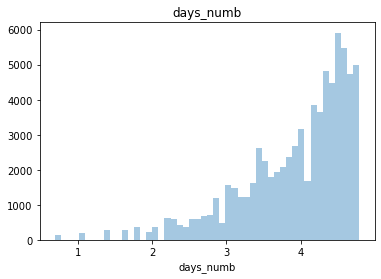

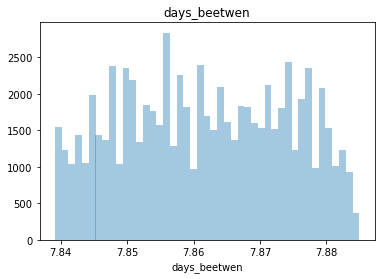

In [145]:
for i in num_:
    plt.figure()
    sns.distplot(train[i][
        train[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

Rank of Matrix: 5
Determinat of matrix: 0.1367
Shape of matrix: (5, 5)


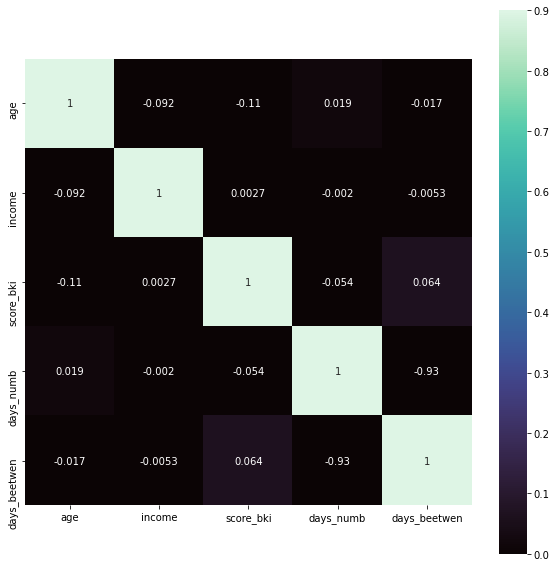

In [146]:
corr_matrix(train[num_])

<AxesSubplot:>

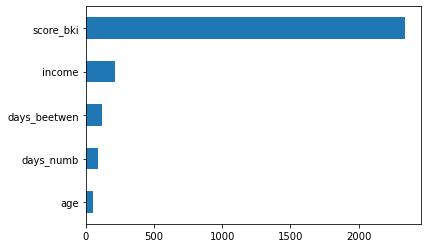

In [147]:
imp_num = Series(f_classif(train[num_], train['default'])[0], index=num_)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

### Большую значимость имеет признак score_bki. Признак days_numb и days_beetwen сильно обратно скоррелированы, удалим days_numb т.к его значимость ниже и график расспределения имеет хвост влево 

In [148]:
train = train.drop('days_numb',axis = 1 )
num_.remove('days_numb')

#  Бинарные признаки

### Строим графики бинарных признаков от значения 'default' 

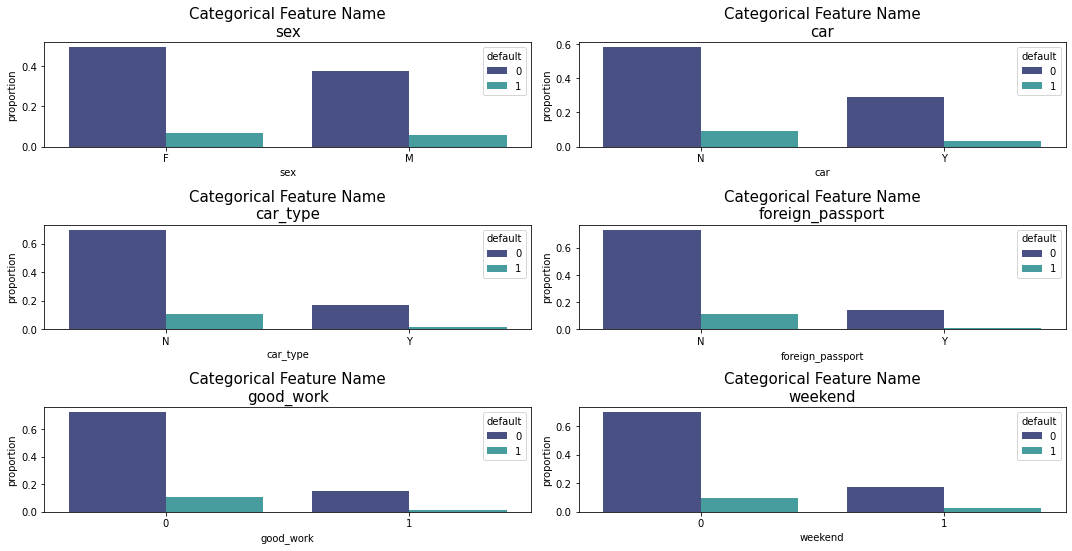

In [149]:
plt.figure(figsize=[15, 20])
i = 1

y, hue = 'proportion', 'default'

for k in bin_:
    plt.subplot(8, 2, i)
    sns.barplot(x=k, y='proportion', hue='default',  data=train[[
                k, 'default']].value_counts(normalize=True).rename('proportion').reset_index(),palette='mako')
    plt.title('Categorical Feature Name\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()    
    

    

Глядя на барплоты, мы можем отметить, что женщины-заемщики, как правило, несут дефолт несколько чаще, чем мужчины.

Заемщики, у которых есть машина, можно считать более надежными. Заемщики, у которых нет машины, как правило, не погашают кредит в два раза чаще, чем те, у кого есть машина.

Те заемщики, у которых есть отечественный автомобиль или нет, склонны к дефолту чаще, чем те, у кого есть иномарка. Однако, если мы хотим видеть распределение более четким, нам нужно создать новую категорию в этом столбце: есть отечественная машина, есть иномарка, нет машины.

Люди, у которых хорошая работа и загранпаспорт, чаще возвращают ссуды, чем те, у кого плохая работа.

Давайте проверим, насколько наши особенности статистически значимы?

Для этого давайте закодируем его в двоичные объекты.

In [150]:
encoder = Preprocessing(train)
for col in bin_:
    encoder.label_encoder(col)

train.sample(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,test,weekend,days_beetwen,month
39792,91986,GRD,0,4.007333,0,0,0,1,4.569060,2,...,3,10.714418,1,4,1,0,0,0,7.847763,4
29919,17803,GRD,0,3.367296,0,0,0,0,4.571893,0,...,3,10.308953,1,4,0,0,0,1,7.875879,1
38194,101102,SCH,0,3.218876,0,0,1,0,4.576369,1,...,3,9.852194,4,1,0,0,0,0,7.843849,4


<AxesSubplot:>

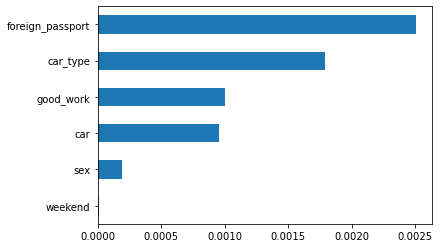

In [151]:
imp_bin = Series(mutual_info_classif(train[bin_], train['default'],
                                     discrete_features=True), index=bin_)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')

#### Наиболее важными являются признаки foreign_passport и car_type . Добавленный нами ранее признак флага выходного дня показывает минимальные показатели. Удалим его

In [152]:
train = train.drop('weekend', axis=1)
bin_.remove('weekend')

Rank of Matrix: 5
Determinat of matrix: 0.4583
Shape of matrix: (5, 5)


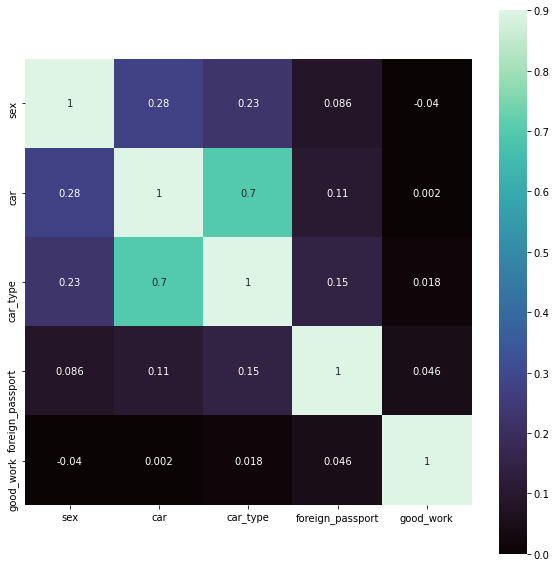

In [153]:
corr_matrix(train[bin_])

У нас сильная корреляция между car и car_type. Это можно объяснить тем, что в столбце car указано наличие автомобиля, а в столбце car_type - наличие иномарки, однако отсутствие автомобиля или то, является ли автомобиль отечественным, в car_type не указывается. В разделе проектирования функций мы объединим информацию из этих столбцов в один. Это позволяет уменьшить матрицу характеристик без потери информации.

Кроме того, автомобиль немного коррелирует с полом.

In [154]:
cat_

['decline_app_cnt',
 'bki_request_cnt',
 'education',
 'work_address',
 'home_address',
 'sna',
 'region_rating',
 'first_time',
 'month']

# Категориальные признаки

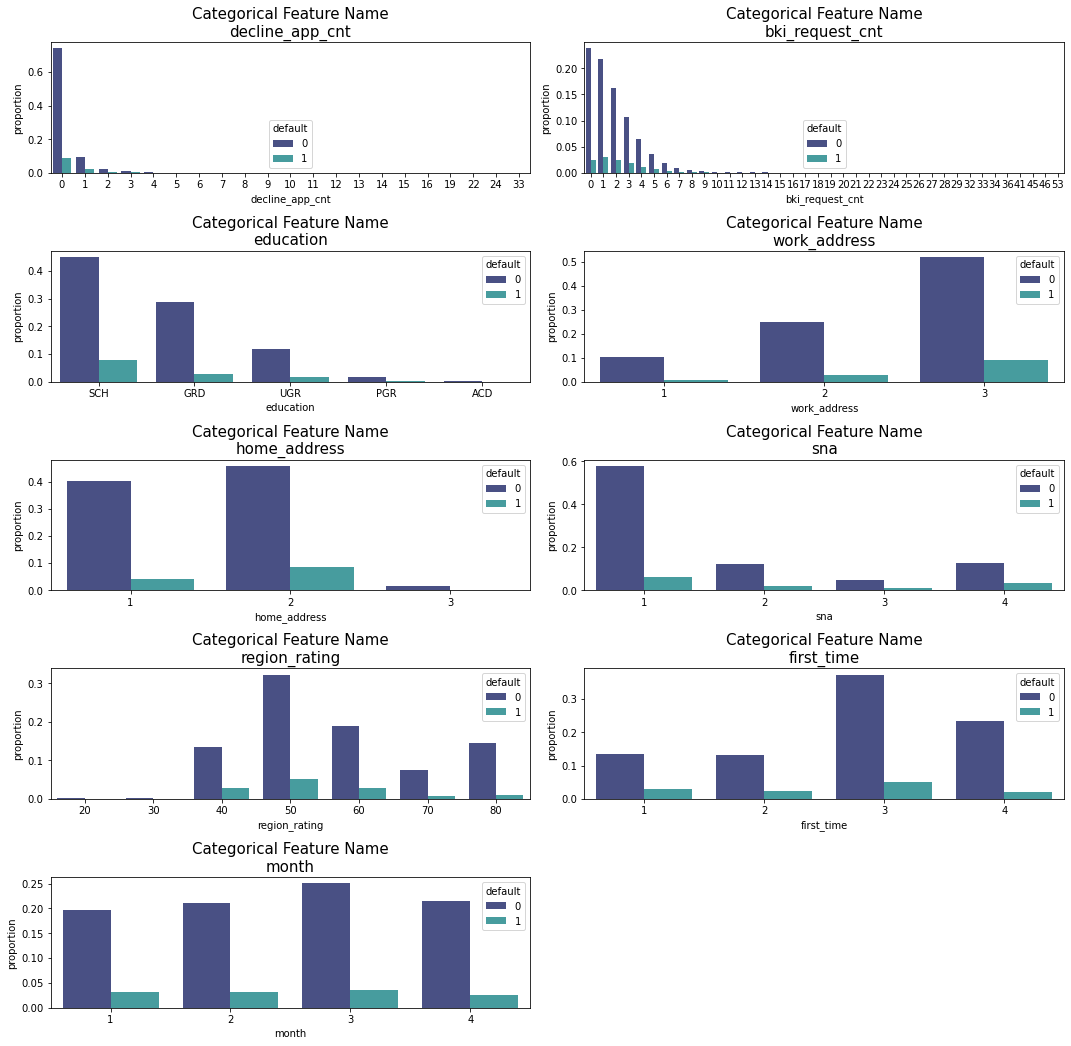

In [155]:
plt.figure(figsize=[15, 20])
i = 1

y, hue = 'proportion', 'default'

for k in cat_:
    plt.subplot(7, 2, i)
    sns.barplot(x=k, y='proportion', hue='default',  data=train[[
                k, 'default']].value_counts(normalize=True).rename('proportion').reset_index(),palette='mako')
    plt.title('Categorical Feature Name\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()    
    

### Мы видим, что признаки decline_app_cnt и bki_request_cnt имеют очень большой разброс значений. На этапе создания новых признаков мы его уменьшим сгруппировав

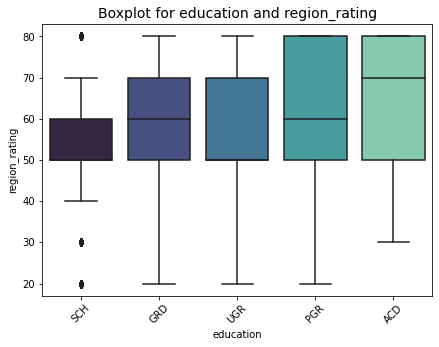

In [156]:
get_boxplot(train,'education','region_rating')

Люди с высоким уровнем образования предпочитают жить в регионе с более высоким уровнем образования.

Хорошо, а теперь давайте посмотрим, как распределяются обанкротившиеся заемщики по region_rating.

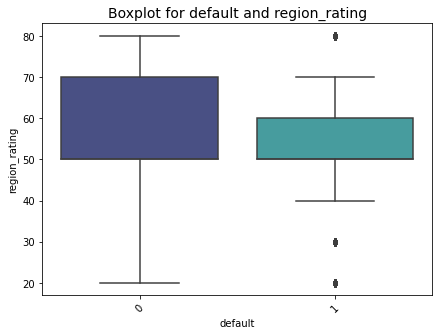

In [157]:
get_boxplot(train,'default','region_rating')

Мы можем видеть, что клиенты по умолчанию живут в регионах среднего уровня. Чем выше рейтинг города, тем меньше вероятность дефолта. Это должно быть хорошее представление для модели.

Интересно, можем ли мы наблюдать какие-то связи между уровнем образования и связью заемщиков с другими клиентами банка? Посмотрим на это.

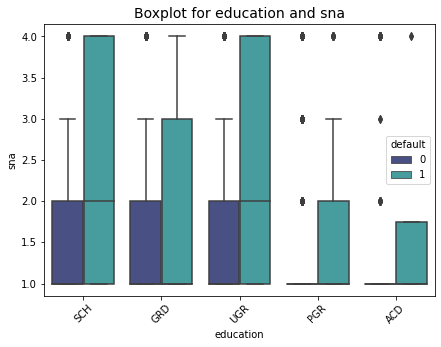

In [158]:
get_boxplot(train,'education','sna',hue='default')

Связи с клиентами банка имеют люди, в основном с низким уровнем образования. Возможно это можно объяснить тем, что люди с низким образованием работают в больших коллективах (заводы, фабрики) и обмен информации лучше или людям с высоким образованием не нужны поручители. Дефолтных клиентов также больше именно в этих категориях.

In [159]:
train['has_no_guarantor'] = 0
train['has_no_guarantor'] = train[['education','has_no_guarantor']].apply(lambda x:has_no_garant(*x),axis=1)

In [160]:
bin_ = bin_ + ['has_no_guarantor']

In [161]:
for col in cat_:
    pre_processing(col,train)

<AxesSubplot:>

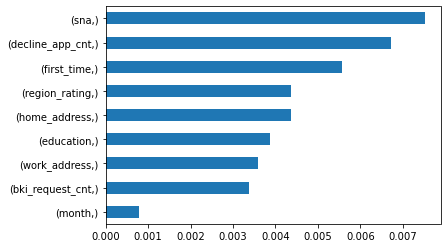

In [162]:
imp_cat = pd.Series(mutual_info_classif(train[cat_], train['default'], 
                                     discrete_features=True), index=[cat_])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Rank of Matrix: 9
Determinat of matrix: 0.278
Shape of matrix: (9, 9)


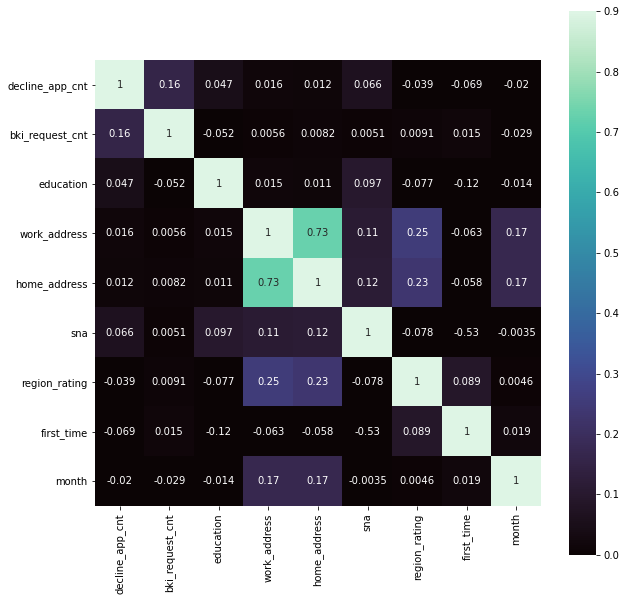

In [163]:
corr_matrix(train[cat_])

У нас довольно сильная корреляция между sna и first_time. Кроме того, эти два столбца имеют наибольшее значение для целевой переменной. Можно предположить, что эти две особенности можно объяснить следующим образом: этот человек давно является клиентом банка и, как следствие, приобрел связи с другими клиентами (возможно, поручителями). Признак меяца имеет статистическое значение. Как-то месяц соотносится с work_address

Домашний и рабочий адреса также коррелировали. Нам нужно подумать, что мы можем сделать с этими признаками

### Посмотрим полную матрицу корреляции

In [164]:
train.isna().sum()

client_id           0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
test                0
days_beetwen        0
month               0
has_no_guarantor    0
dtype: int64

In [165]:
train

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,test,days_beetwen,month,has_no_guarantor
0,25905,3,1,4.127134,1,1,0,0,4.574621,1,...,1,9.798127,3,0,0,0,0,7.873217,1,0
1,63161,3,0,4.077537,0,0,0,0,4.579521,3,...,2,9.852194,3,0,0,0,0,7.858254,2,0
2,25887,3,1,3.218876,1,0,2,0,4.580794,1,...,1,10.308953,0,3,1,0,0,7.873217,1,0
3,16222,3,0,3.970292,0,0,0,0,4.574118,2,...,2,9.210340,0,2,0,0,0,7.876638,0,0
4,101655,1,1,3.871201,0,0,0,1,4.582467,1,...,2,10.308953,0,3,1,0,0,7.843849,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,1,0,3.806662,0,0,0,0,4.576852,3,...,1,9.740969,3,3,0,0,0,7.861342,2,0
73795,76821,3,1,3.713572,1,1,0,0,4.574113,1,...,1,11.156251,0,3,0,0,0,7.853605,2,0
73796,103695,3,1,3.433987,0,0,0,0,4.579723,4,...,2,10.714418,1,1,0,0,0,7.842279,3,0
73797,861,3,0,3.367296,0,0,0,1,4.580064,3,...,2,9.472705,1,2,0,1,0,7.883823,0,0


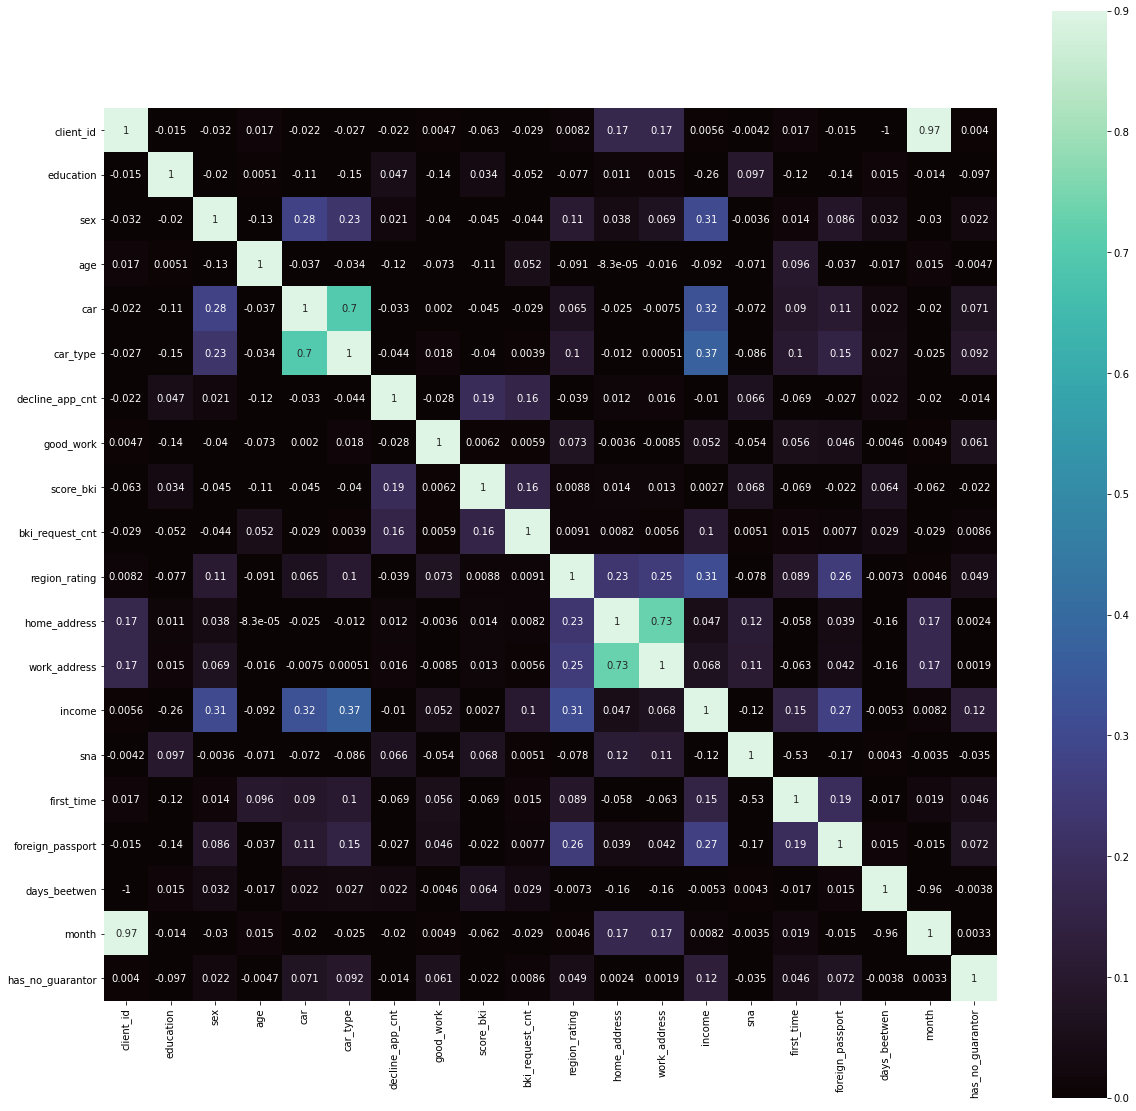

In [166]:
corr_matrix(train.drop(['default','test'],axis=1),det=False,pltx=20,plty=20)

Мы видим полную корреляцию признака client_id и month (порядковый номер дня в году). Это указывает на определенную систему присвоения номера клиента. Скорее всего, эти знаки дадут нам что-нибудь полезное.

car_type коррелирует с доходом. Это можно объяснить предположением, что если у заемщика больше доходов, то у него лучше машина, и наоборот.

sna имеет довольно сильную корреляцию с foreign_passport

> ### Выводы

**Бинарные:**

Автомобиль и car_type сильно коррелированы.

В столбце car указано наличие автомобиля, а в столбце car_type - наличие иномарки. Объедините их дальше

Количество дефолтных заемщиков мужского и женского пола практически одинаково. Однако женщины чаще ссужают деньги.

**Категориальные:**

Люди с низким уровнем образования не возвращают кредиты чаще, чем люди с высоким уровнем образования.

Больше отношений заемщика с другими клиентами - больше просроченных платежей. Признак **'has no guarantors'**, может быть добавлен людям с высоким уровнем образования.

Люди с высоким уровнем образования предпочитают жить в регионе с более высоким уровнем образования.

Чем выше рейтинг города, тем меньше вероятность дефолта

Корреляция между **'sna'** и **'first_time'**, **'home_address'** и **'work_address'**.

**Числовые:**

**'score_bki'** имеет распределение близкое к нормальному. Это уже масштабируется ЗППП (скорее всего)

У данных есть выбросы. Тем не менее, лучше некоторые функции преобразовать в категориальный тип.

Нет сильной корреляции между функциями

Car_type коррелирует с доходом

Sna имеет довольно сильную корреляцию с foreign_passport

**Статистически наиболее значимые:**

'foreign_passport'

'car_type'

'sna'

'first_time'

'region_rating'

'Score_bki'

'decline_app_cnt'

Поскольку у нас нет очевидной корреляции и связи между признаками, лучше использовать модели descicion tree или logistic regressions.


# Наивная модель

In [167]:
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,NaN,1
36345,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,NaN,1
36346,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN,1
36347,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN,1


# Feature Engineering

In [168]:
# df_1 = df.copy()

# car & car_type

In [169]:
df =  df.drop('client_id', axis=1)

In [170]:
edu_name = df['education'].value_counts().index.to_list() # Получаем список значений
edu_distr = df['education'].value_counts(normalize=True).values # Получаем список вероятностей
missing = df['education'].isnull() # Флаги с наличием пропусков
df.loc[missing, ['education']] = np.random.choice(
    edu_name, size=len(df[missing]), p=edu_distr) # Подставляем значения из списка имен в соответствии в вероятностью встречи имени

In [171]:
encoder = Preprocessing(df)
for i in list(['sex','car','car_type','foreign_passport', 'good_work']):
    encoder.label_encoder(i)

In [172]:
df['car_comb'] = df['car'] + df['car_type']
df = df.drop(['car','car_type'],axis=1)

In [173]:
df

,app_date,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test,car_comb
0,01FEB2014,SCH,1,62,0,0,-2.008753,1,50,1,2,18000,4,1,0,0.0,0,2
1,12MAR2014,SCH,0,59,0,0,-1.532276,3,50,2,3,19000,4,1,0,0.0,0,0
2,01FEB2014,SCH,1,25,2,0,-1.408142,1,80,1,2,30000,1,4,1,0.0,0,1
3,23JAN2014,SCH,0,53,0,0,-2.057471,2,50,2,3,10000,1,3,0,0.0,0,0
4,18APR2014,GRD,1,48,0,1,-1.244723,1,60,2,3,30000,1,4,1,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,31MAR2014,SCH,0,37,1,0,-1.744976,3,50,2,3,15000,4,1,0,NaN,1,0
36345,25APR2014,GRD,0,64,0,0,-2.293781,3,60,1,2,200000,1,4,0,NaN,1,2
36346,30MAR2014,GRD,1,31,2,0,-0.940752,1,50,1,2,60000,4,2,0,NaN,1,0
36347,07JAN2014,UGR,0,27,1,0,-1.242392,2,80,2,3,30000,1,1,0,NaN,1,0


# age

In [174]:
def age_to_cat(age):
    if age <= 28:
        cat_age = 'young'
        return cat_age             
    if 28 < age <= 35:
        cat_age = 'semi-man'
        return cat_age
    if 35 < age <= 50:
        cat_age = 'midle'
        return cat_age
    if age > 50:
        cat_age = 'old'
        return cat_age

In [175]:
df['age_cat'] = 0
df['age_cat'] = df['age'].apply(lambda x:age_to_cat(x))

In [176]:
df

,app_date,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test,car_comb,age_cat
0,01FEB2014,SCH,1,62,0,0,-2.008753,1,50,1,2,18000,4,1,0,0.0,0,2,old
1,12MAR2014,SCH,0,59,0,0,-1.532276,3,50,2,3,19000,4,1,0,0.0,0,0,old
2,01FEB2014,SCH,1,25,2,0,-1.408142,1,80,1,2,30000,1,4,1,0.0,0,1,young
3,23JAN2014,SCH,0,53,0,0,-2.057471,2,50,2,3,10000,1,3,0,0.0,0,0,old
4,18APR2014,GRD,1,48,0,1,-1.244723,1,60,2,3,30000,1,4,1,0.0,0,0,midle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,31MAR2014,SCH,0,37,1,0,-1.744976,3,50,2,3,15000,4,1,0,NaN,1,0,midle
36345,25APR2014,GRD,0,64,0,0,-2.293781,3,60,1,2,200000,1,4,0,NaN,1,2,old
36346,30MAR2014,GRD,1,31,2,0,-0.940752,1,50,1,2,60000,4,2,0,NaN,1,0,semi-man
36347,07JAN2014,UGR,0,27,1,0,-1.242392,2,80,2,3,30000,1,1,0,NaN,1,0,young


<AxesSubplot:xlabel='age_cat', ylabel='count'>

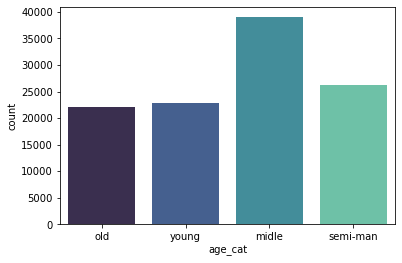

In [177]:
sns.countplot(df['age_cat'],palette='mako')

# decline_app_cnt

<AxesSubplot:xlabel='decline_app_cnt', ylabel='proportion'>

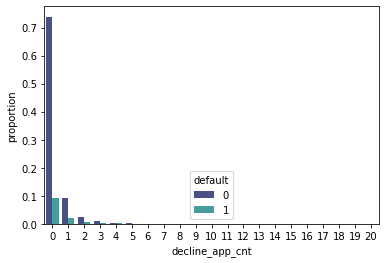

In [178]:
sns.barplot(x='decline_app_cnt', y='proportion', hue='default',  data=train[[
                'decline_app_cnt', 'default']].value_counts(normalize=True).rename('proportion').reset_index(),palette='mako')

#### Разделим на группы:
1. 0
2. 1
3. 3
4. более или равно 4

   


In [179]:
df['decline_cat'] = df['decline_app_cnt'].apply(lambda x: 4 if x >= 4 else x)

In [180]:
df = df.drop('decline_app_cnt',axis=1)

# bki_request_cnt

<AxesSubplot:xlabel='bki_request_cnt', ylabel='proportion'>

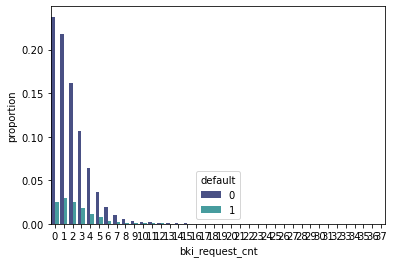

In [181]:
sns.barplot(x='bki_request_cnt', y='proportion', hue='default',  data=train[[
                'bki_request_cnt', 'default']].value_counts(normalize=True).rename('proportion').reset_index(),palette='mako')

#### Разделим на группы:
1. 0
2. 1
3. 3
4. 4
5. 5
6. 6
7. более или равно 7

   


In [182]:
df['bki_request_cat'] = df['bki_request_cnt'].apply(lambda x: 7 if x >= 7 else x)

In [183]:
df = df.drop('bki_request_cnt',axis=1)

# home_address & work_address

In [184]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
data = df[['work_address','home_address']].values
scaler = StandardScaler()

scaled_data = scaler.fit_transform(data)
pca = PCA(n_components=1)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
df['pca_address'] = pca_data

In [185]:
df = df.drop(['home_address','work_address'],axis=1)

# app_date

In [186]:
df['app_date'] = pd.to_datetime(
    df['app_date'])  # Преобразуем в datetime

df['days_beetwen'] = df['app_date'].apply(
    lambda x: (get_days_beetwen(x)
               ))  # Кол- во дней между подачей заявки и сегодняшним числом
df['month'] = df['app_date'].apply(lambda x: (month(x)))
df = df.drop('app_date',axis=1) # Удалим столбец app_date 

# has_no_guarantor

In [187]:
df['has_no_guarantor'] = 0
df['has_no_guarantor'] = df[['education','has_no_guarantor']].apply(lambda x:has_no_garant(*x),axis=1)

# ENCODING

In [188]:
df['pca_address'] = df['pca_address'] + 5

<AxesSubplot:>

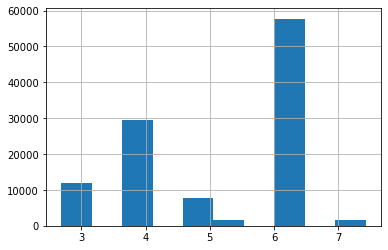

In [189]:
df['pca_address'].hist()

# Делаем fit_transform для категориальных тренировочной

In [190]:
to_encode_cat = ['education','age_cat']
for i in to_encode_cat:
    pre_processing(i,df)

In [191]:
to_encode_bin = ['sex', 'foreign_passport', 'good_work', 'has_no_guarantor']
for i in to_encode_bin:
    pre_processing(i,df)

In [192]:
df

,education,sex,age,good_work,score_bki,region_rating,income,sna,first_time,foreign_passport,default,test,car_comb,age_cat,decline_cat,bki_request_cat,pca_address,days_beetwen,month,has_no_guarantor
0,3,1,62,0,-2.008753,50,18000,4,1,0,0.0,0,2,1,0,1,3.717427,2626,2,0
1,3,0,59,0,-1.532276,50,19000,4,1,0,0.0,0,0,1,0,3,6.086059,2587,3,0
2,3,1,25,0,-1.408142,80,30000,1,4,1,0.0,0,1,3,2,1,3.717427,2626,2,0
3,3,0,53,0,-2.057471,50,10000,1,3,0,0.0,0,0,1,0,2,6.086059,2635,1,0
4,1,1,48,1,-1.244723,60,30000,1,4,1,0.0,0,0,0,0,1,6.086059,2550,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,3,0,37,0,-1.744976,50,15000,4,1,0,NaN,1,0,0,1,3,6.086059,2568,3,0
36345,1,0,64,0,-2.293781,60,200000,1,4,0,NaN,1,2,1,0,3,3.717427,2543,4,0
36346,1,1,31,0,-0.940752,50,60000,4,2,0,NaN,1,0,2,2,1,3.717427,2569,3,0
36347,4,0,27,0,-1.242392,80,30000,1,1,0,NaN,1,0,3,1,2,6.086059,2651,1,0


In [193]:
bin_

['sex', 'car', 'car_type', 'foreign_passport', 'good_work', 'has_no_guarantor']

In [194]:
encoder_train= Preprocessing(df[df['test']==0])
cols_to_hot = ['education','region_rating','sna','first_time','car_comb','age_cat','decline_cat','bki_request_cat', 'month']
for col in cols_to_hot:
    df_train_hotted = encoder_train.hot_enc(col)


In [195]:
encoder_test= Preprocessing(df[df['test']==1])
cols_to_hot = ['education','region_rating','sna','first_time','car_comb','age_cat','decline_cat','bki_request_cat', 'month']
for col in cols_to_hot:
    df_test_hotted = encoder_test.hot_enc(col)

In [196]:
df_train_hotted

,education,sex,age,good_work,score_bki,region_rating,income,sna,first_time,foreign_passport,...,hot_encode_2,hot_encode_3,hot_encode_4,hot_encode_5,hot_encode_6,hot_encode_7,hot_encode_1,hot_encode_2,hot_encode_3,hot_encode_4
0,3,1,62,0,-2.008753,50,18000,4,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3,0,59,0,-1.532276,50,19000,4,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,1,25,0,-1.408142,80,30000,1,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,0,53,0,-2.057471,50,10000,1,3,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,1,48,1,-1.244723,60,30000,1,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,1,0,45,0,-1.792064,50,17000,4,4,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73795,3,1,41,0,-2.058029,50,70000,1,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73796,3,1,31,0,-1.512635,80,45000,2,2,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
73797,3,0,29,1,-1.479334,50,13000,2,3,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [197]:
df['pca_address'] = df['pca_address'] + 5

In [198]:
'''ЛОГАРИФМИРОВАНИЕ'''
to_log = ['age', 'income', 'days_beetwen','pca_address']
for col in to_log:
    df[col] = np.log(df[col])

In [199]:
to_scal = ['age', 'income', 'days_beetwen','pca_address']
scaler_num = RobustScaler()
df_train_scaled = scaler_num.fit_transform(df_train_hotted[to_scal].values)
df_test_scaled = scaler_num.transform(df_test_hotted[to_scal].values)

df_train_hotted = df_train_hotted.drop(to_scal,axis=1)
df_test_hotted = df_test_hotted.drop(to_scal,axis=1)

In [200]:
df_train_scaled.shape

(73799, 4)

In [201]:
df_train_hotted

,education,sex,good_work,score_bki,region_rating,sna,first_time,foreign_passport,default,test,...,hot_encode_2,hot_encode_3,hot_encode_4,hot_encode_5,hot_encode_6,hot_encode_7,hot_encode_1,hot_encode_2,hot_encode_3,hot_encode_4
0,3,1,0,-2.008753,50,4,1,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3,0,0,-1.532276,50,4,1,0,0.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,1,0,-1.408142,80,1,4,1,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,0,0,-2.057471,50,1,3,0,0.0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,1,1,-1.244723,60,1,4,1,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,1,0,0,-1.792064,50,4,4,0,0.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73795,3,1,0,-2.058029,50,1,4,0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
73796,3,1,0,-1.512635,80,2,2,0,0.0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
73797,3,0,1,-1.479334,50,2,3,0,1.0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [202]:
df_train_hotted.shape

(73799, 60)

In [203]:
df_test_hotted.shape

(36349, 60)

In [204]:
X = np.hstack([df_train_scaled,df_train_hotted.drop(['default','test'],axis=1).values ])
y = df_train_hotted[['default']]
X_valid = np.hstack([df_test_scaled,df_test_hotted.drop(['default','test'],axis=1).values ])


In [205]:
X.shape

(73799, 62)

In [206]:
model = LogisticRegression()

In [207]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,random_state=42)

In [208]:
model.fit(X_train,y_train)

LogisticRegression()

In [209]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

In [210]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93     16089
         1.0       0.51      0.03      0.06      2361

    accuracy                           0.87     18450
   macro avg       0.69      0.51      0.50     18450
weighted avg       0.83      0.87      0.82     18450



In [211]:
df_report = pd.DataFrame(columns={'ROC-AUG'}, data=[0])

df_report['ROC-AUG'] = roc_auc_score(y_test, y_pred_proba)
df_report['PR-AUC'] = precision_score(y_test,y_pred)
df_report['F1'] = f1_score(y_test,y_pred)
df_report['precision_0'] = precision_score(y_test,y_pred,pos_label=0)
df_report['recall_0'] = recall_score(y_test,y_pred,pos_label=0)
df_report['precision_1'] = precision_score(y_test,y_pred,pos_label=1)
df_report['recall_1'] = recall_score(y_test,y_pred,pos_label=1)

df_report.index = ['LogisticRegression']

In [212]:
df_report

,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.724649,0.510204,0.059809,0.875102,0.995525,0.510204,0.031766


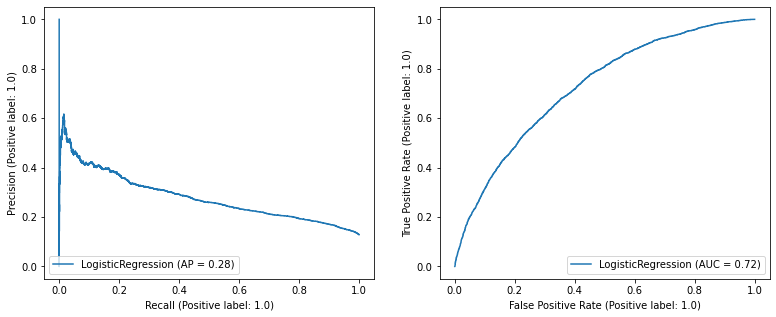

In [213]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))

plot_precision_recall_curve(model, X_test, y_test,ax=ax1)
plot_roc_curve(model, X_test, y_test, ax=ax2);

PR-REC AUC очень низкий, что говорит о том, что алгоритм пока не способен как-либо различать классы, больше всего он присваивает объектам класс 0, попробуем подобрать наилучшие параметры, а также сделаем стратификацию, которая часто применяется при дbбалансе классов

In [214]:
# Grid Search
model_skf = LogisticRegression(class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'C':np.linspace(0.001, 10, 10), 'penalty': ['l1','l2']}

# refit - по умолчанию, в предикте уже используем лучшую модель
clf_model = GridSearchCV(
    model_skf, param, scoring='roc_auc', refit=True, cv=skf)
clf_model.fit(X_train,y_train)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_model.best_score_, clf_model.best_params_))

Best roc_auc: 0.7349, with best C: {'C': 3.334, 'penalty': 'l2'}


In [215]:
# Функция для возвращения таблицы с метриками
def get_scores(report_df, model, X_test, y_test, name):       
    
    report = pd.DataFrame(columns={'ROC-AUG'}, data=[0])
    report['ROC-AUG'] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    report['PR-AUC'] = precision_score(y_test,model.predict(X_test))
    report['F1'] = f1_score(y_test,model.predict(X_test)) 
    report['precision_0'] = precision_score(y_test,model.predict(X_test),pos_label=0)
    report['recall_0'] = recall_score(y_test,model.predict(X_test),pos_label=0)
    report['precision_1'] = precision_score(y_test,model.predict(X_test),pos_label=1)
    report['recall_1'] = recall_score(y_test,model.predict(X_test),pos_label=1)

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

In [216]:
df_report = get_scores(df_report,clf_model, X_test,y_test, 'LogisticRegression_skf')

In [217]:
df_report

,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.724649,0.510204,0.059809,0.875102,0.995525,0.510204,0.031766
LogisticRegression_skf,0.724719,0.223418,0.332612,0.928726,0.668158,0.223418,0.650572


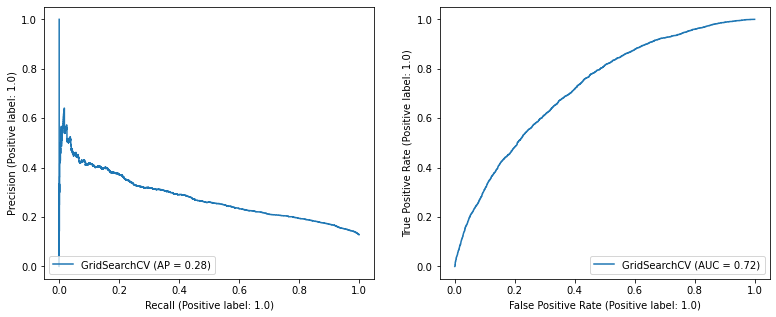

In [218]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))

plot_precision_recall_curve(clf_model, X_test, y_test,ax=ax1)
plot_roc_curve(clf_model, X_test, y_test, ax=ax2);

**Видим, что в классе 0 поднялась точность и упала полнота, в кассе 1 упала точность и заметно поднялась полнота. В целом подросла f1, но большой разницы при балансировке классов не видно с учетом поиска лучших параметров и статифицированной выборки для обучения.**

**Добавим объектов недостоющего класса**

In [219]:
oversample = RandomOverSampler(sampling_strategy=1.0)
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [220]:
# Grid Search
model_skf = LogisticRegression()
skf = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'C':np.linspace(0.001, 10, 10), 'penalty': ['l1','l2']}

# refit - по умолчанию, в предикте уже используем лучшую модель
clf_model_over = GridSearchCV(
    model_skf, param, scoring='roc_auc', refit=True, cv=skf, verbose =1)
clf_model_over.fit(X_over,y_over)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_model.best_score_, clf_model.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best roc_auc: 0.7349, with best C: {'C': 3.334, 'penalty': 'l2'}


In [221]:
df_report = get_scores(df_report,clf_model_over, X_test,y_test, 'LogisticRegression_skf_imb')

In [222]:
df_report

,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.724649,0.510204,0.059809,0.875102,0.995525,0.510204,0.031766
LogisticRegression_skf,0.724719,0.223418,0.332612,0.928726,0.668158,0.223418,0.650572
LogisticRegression_skf_imb,0.724367,0.223765,0.332718,0.928498,0.669899,0.223765,0.648454


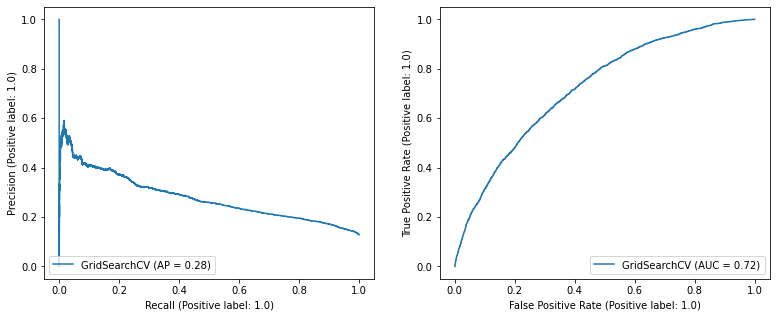

In [223]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))

plot_precision_recall_curve(clf_model_over, X_test, y_test,ax=ax1)
plot_roc_curve(clf_model_over, X_test, y_test, ax=ax2);

После использоания oversampling методики без параметра балансировки в модели, в целом все значения оценок вернулись на исходные значения. Заметим, что хорошо работает встроенный параметр class_weight='balanced'.

**Возможно себя лучше покажут решающие деревья**

## Random Forest

In [224]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

df_report = get_scores(df_report,rf, X_test,y_test, 'RandomForestClassifier')

In [225]:
df_report

,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.724649,0.510204,0.059809,0.875102,0.995525,0.510204,0.031766
LogisticRegression_skf,0.724719,0.223418,0.332612,0.928726,0.668158,0.223418,0.650572
LogisticRegression_skf_imb,0.724367,0.223765,0.332718,0.928498,0.669899,0.223765,0.648454
RandomForestClassifier,0.695726,0.330097,0.027597,0.873167,0.995711,0.330097,0.014401


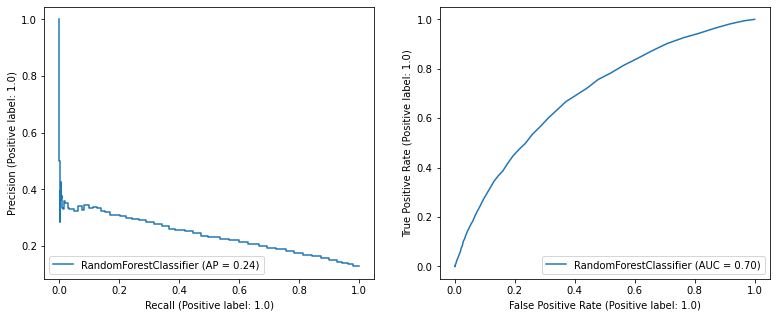

In [226]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))

plot_precision_recall_curve(rf, X_test, y_test,ax=ax1)
plot_roc_curve(rf, X_test, y_test, ax=ax2);

# Чет поплыли

In [227]:
y_pred_valid = model.predict(X_valid)
y_pred_proba_valid = model.predict_proba(X_valid)[:,1]

In [228]:
# Grid Search
rf_skf = RandomForestClassifier(class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'bootstrap':[True],
        'max_depth':[10,30],
        'n_estimators':[600,1000]}


clf_rf = GridSearchCV(
    rf_skf, param, scoring='roc_auc', refit=True, cv=skf, verbose =3, n_jobs=-1)
clf_rf.fit(X_train,y_train)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_model.best_score_, clf_model.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best roc_auc: 0.7349, with best C: {'C': 3.334, 'penalty': 'l2'}


In [229]:
df_report = get_scores(df_report,clf_rf, X_test,y_test, 'RandomForestClassifier_skf')

In [230]:
df_report

,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.724649,0.510204,0.059809,0.875102,0.995525,0.510204,0.031766
LogisticRegression_skf,0.724719,0.223418,0.332612,0.928726,0.668158,0.223418,0.650572
LogisticRegression_skf_imb,0.724367,0.223765,0.332718,0.928498,0.669899,0.223765,0.648454
RandomForestClassifier,0.695726,0.330097,0.027597,0.873167,0.995711,0.330097,0.014401
RandomForestClassifier_skf,0.720399,0.245244,0.340541,0.920079,0.748462,0.245244,0.556967


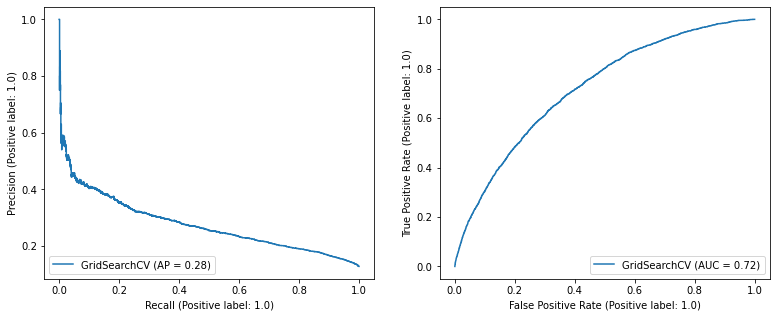

In [231]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))

plot_precision_recall_curve(clf_rf, X_test, y_test,ax=ax1)
plot_roc_curve(clf_rf, X_test, y_test, ax=ax2);

Решающие деревья с использованием стратификации и балансировки показали результат немного лучше логистической регрессии с стратификацией. Немного вырос PR-AUC, F1, полнота класса 0 и точность класса 1

In [232]:
# Grid Search
rf_skf = RandomForestClassifier()
skf = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'bootstrap':[True],
        'max_depth':[10,30],
        'n_estimators':[600,1000]}


clf_rf_over = GridSearchCV(
    rf_skf, param, scoring='roc_auc', refit=True, cv=skf, verbose =3, n_jobs=-1)
clf_rf_over.fit(X_over,y_over)

print('Best roc_auc: {:.4}, with best C: {}'.format(clf_model.best_score_, clf_model.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best roc_auc: 0.7349, with best C: {'C': 3.334, 'penalty': 'l2'}


In [233]:
df_report = get_scores(df_report,clf_rf_over, X_test,y_test, 'RandomForestClassifier_skf_over')

In [234]:
df_report

,ROC-AUG,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.724649,0.510204,0.059809,0.875102,0.995525,0.510204,0.031766
LogisticRegression_skf,0.724719,0.223418,0.332612,0.928726,0.668158,0.223418,0.650572
LogisticRegression_skf_imb,0.724367,0.223765,0.332718,0.928498,0.669899,0.223765,0.648454
RandomForestClassifier,0.695726,0.330097,0.027597,0.873167,0.995711,0.330097,0.014401
RandomForestClassifier_skf,0.720399,0.245244,0.340541,0.920079,0.748462,0.245244,0.556967
RandomForestClassifier_skf_over,0.700586,0.323232,0.112045,0.877416,0.979178,0.323232,0.067768


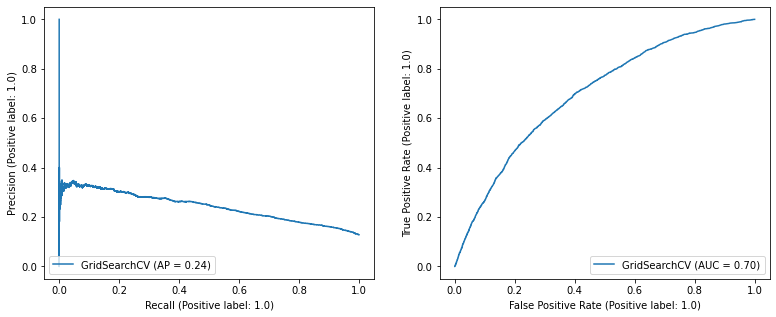

In [235]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))

plot_precision_recall_curve(clf_rf_over, X_test, y_test,ax=ax1)
plot_roc_curve(clf_rf_over, X_test, y_test, ax=ax2);

In [236]:
clf_rf_over.predict_proba(X_valid)[:, 1]

array([0.034     , 0.357     , 0.08940741, ..., 0.39536379, 0.679     ,
       0.29191498])

In [237]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93     16089
         1.0       0.51      0.03      0.06      2361

    accuracy                           0.87     18450
   macro avg       0.69      0.51      0.50     18450
weighted avg       0.83      0.87      0.82     18450



In [238]:
id_test = test['client_id']

In [242]:
submission = pd.DataFrame({'client_id': id_test, 
                            'default': clf_rf.predict_proba(X_valid)[:, 1]})
submission.to_csv('submission.csv', index=False)

In [243]:
submission

,client_id,default
0,74835,0.213722
1,17527,0.601252
2,75683,0.353457
3,26883,0.351183
4,28862,0.094967
...,...,...
36344,83775,0.752245
36345,106254,0.169587
36346,81852,0.642678
36347,1971,0.694442
